In [1]:
%load_ext rpy2.ipython
# Turning on in-IPy R capabilities

In [67]:
%%R
library(phyloseq)
library(vegan)
library(plyr)
library(dplyr)
library(ggplot2)

In [50]:
%%R
#Creating the physeq object from our tree and biom table with taxonomic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../../../16S/SeqData/otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)

In [51]:
%%R
Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [52]:
%%R
physeq.noSmall = subset_samples(physeq,sample_sums(physeq)>1500)

In [53]:
%%R
physeq = physeq.noSmall
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
physeq = transform_sample_counts(physeq, function(x) x / sum(x))
#physeq = subset_samples(physeq, Trtmt!="Heavy Fraction")
#physeq = subset_samples(physeq, Trtmt!="Kaolinite")
physeq = subset_samples(physeq, Trtmt!="Blank")
#physeq = subset_samples(physeq, Trtmt!="Quartz")
#physeq = subset_samples(physeq, Trtmt!="Ferrihydrite")
#physeq = subset_samples(physeq, Trtmt!="Soil")

In [85]:
%%R
citation("vegan")


To cite package ‘vegan’ in publications use:

  Jari Oksanen, F. Guillaume Blanchet, Roeland Kindt, Pierre Legendre,
  Peter R. Minchin, R. B. O'Hara, Gavin L. Simpson, Peter Solymos, M.
  Henry H. Stevens and Helene Wagner (2015). vegan: Community Ecology
  Package. R package version 2.3-0.
  http://CRAN.R-project.org/package=vegan

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {vegan: Community Ecology Package},
    author = {Jari Oksanen and F. Guillaume Blanchet and Roeland Kindt and Pierre Legendre and Peter R. Minchin and R. B. O'Hara and Gavin L. Simpson and Peter Solymos and M. Henry H. Stevens and Helene Wagner},
    year = {2015},
    note = {R package version 2.3-0},
    url = {http://CRAN.R-project.org/package=vegan},
  }

ATTENTION: This citation information has been auto-generated from the
package DESCRIPTION file and may need manual editing, see
‘help("citation")’.



Error in dev.off() : 
  QuartzBitmap_Output - unable to open file '/var/folders/d2/qqsv2qxd5fjf4k455pzytwgh0000gn/T/tmpCRLyrG/Rplots001.png'
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                                    diff         lwr         upr     p adj
Heavy Fraction-Ferrihydrite  0.001416874 -0.13701896  0.13985271 0.9999998
Kaolinite-Ferrihydrite       0.137620637  0.03297298  0.24226829 0.0043097
Quartz-Ferrihydrite         -0.013338358 -0.09094714  0.06427042 0.9883938
Soil-Ferrihydrite           -0.162218477 -0.23849291 -0.08594405 0.0000017
Kaolinite-Heavy Fraction     0.136203763 -0.02076772  0.29317525 0.1180133
Quartz-Heavy Fraction       -0.014755232 -0.15515480  0.12564433 0.9982547
Soil-Heavy Fraction         -0.163635350 -0.30330175 -0.02396895 0.0139978
Quartz-Kaolinite            -0.150958995 -0.25819093 -0.04372706 0.0019237
Soil-Kaolinite              -0.299839114 -0.4061093

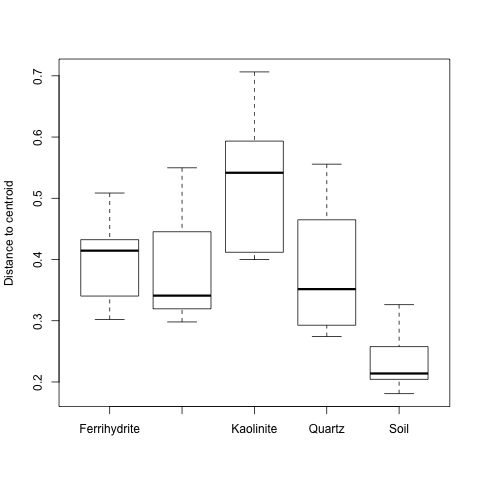

In [84]:
%%R
df = as(sample_data(physeq), "data.frame")
d = distance(physeq, method = "bray")
sampdat = sample_data(physeq)
groups = as.factor(sampdat$Trtmt)
x = betadisper(d, groups)
boxplot(x, ylab = "Distance to centroid")
anova(x)
TukeyHSD(x, ordered = FALSE, conf.level = 0.95)
# Performing test of beta dispersion - the permanova/adonis test requires that groups have similar dispersion.
# This doesn't look outrageously bad here. Some worry re. Kaolinite, as expected, and soils look tight too.

In [42]:
%%R
df = as(sample_data(physeq), "data.frame")
d = distance(physeq, method = "bray")

d.adonis = adonis(d ~ sample_data(physeq)$Month + sample_data(physeq)$Trtmt, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(physeq)$Month + sample_data(physeq)$Trtmt,      data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
sample_data(physeq)$Month  1    0.2669 0.26694  1.6345 0.04511  0.055 .  
sample_data(physeq)$Trtmt  1    0.7512 0.75123  4.5999 0.12695  0.001 ***
Residuals                 30    4.8995 0.16332         0.82794           
Total                     32    5.9176                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


There is a significant effect of both month and treatment, across samples

In [7]:
%%R
physeq.QS = subset_samples(physeq, Trtmt == c("Soil","Quartz"))
physeq.FS = subset_samples(physeq, Trtmt == c("Soil","Ferrihydrite"))
physeq.QF = subset_samples(physeq, Trtmt == c("Quartz","Ferrihydrite"))

In [8]:
%%R
ps = physeq.QS
df = as(sample_data(ps), "data.frame")
d = distance(ps, method = "bray")

d.adonis = adonis(d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt,      data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
sample_data(ps)$Month  1   0.09045 0.09045  0.8509 0.03781  0.479    
sample_data(ps)$Trtmt  1   1.02607 1.02607  9.6527 0.42894  0.001 ***
Residuals             12   1.27558 0.10630         0.53325           
Total                 14   2.39211                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [9]:
%%R
ps = physeq.FS
df = as(sample_data(ps), "data.frame")
d = distance(ps, method = "bray")

d.adonis = adonis(d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt,      data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
sample_data(ps)$Month  1   0.17345 0.17345  1.5799 0.05869  0.159    
sample_data(ps)$Trtmt  1   1.24509 1.24509 11.3409 0.42127  0.001 ***
Residuals             14   1.53703 0.10979         0.52005           
Total                 16   2.95557                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [10]:
%%R
ps = physeq.QF
df = as(sample_data(ps), "data.frame")
d = distance(ps, method = "bray")

d.adonis = adonis(d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt, df)
d.adonis


Call:
adonis(formula = d ~ sample_data(ps)$Month + sample_data(ps)$Trtmt,      data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)   
sample_data(ps)$Month  1   0.33423 0.33423  2.1606 0.11609  0.016 * 
sample_data(ps)$Trtmt  1   0.37921 0.37921  2.4514 0.13171  0.005 **
Residuals             14   2.16572 0.15469         0.75220          
Total                 16   2.87916                 1.00000          
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
